In [1]:
# Reprojection (1)

In [8]:
import numpy as np
import fiona as fio
import rasterio as rio
from fiona.crs import from_epsg
from pyproj import Proj, transform
import matplotlib.pyplot as plt

In [3]:
# Destination crs

# Read raster data and get crs

def get_epsg_from_raster(raster_address):
    with rio.open(raster_address) as f:
        band_crs = f.crs
        destination_epsg = band_crs['init'][5:]
        destination_epsg = int(destination_epsg)
    return destination_epsg

file_location = 'data/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band5.tif'
epsg = get_epsg_from_raster(file_location)
epsg

32634

In [4]:
class VectorData:
    
    def __init__(self, filename):
        self.v_file = filename
        self.geometry = {}
        self.properties = None
        self.vec_crs = None
        self.vec_schema = None
        
    def get_vector_data(self, parameters='all', write_params=True):
        """input 1: parameters (string)
        parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'
        'all': returns tuple with geometry, properties, crs and schema;
        'none': does not return anything;
        'geometry', 'properties', 'crs' or 'schema': returns chosen parameter.
        input 2: write_params (bool)
        write_params: True, False
        True: store all parameters in the object
        False: do not store anything in the object
        output: chosen parameters as a dict"""
        
        with fio.open(vector_file, 'r') as masking_region:
            geometry = [feature["geometry"] for feature in masking_region]
            properties = [feature['properties'] for feature in masking_region]
            vec_crs = masking_region.crs
            vec_schema = masking_region.schema
        
        if write_params:
            print('--- Object geometry, properties, crs and schema updated ---')
            self.geometry = geometry
            self.properties = properties
            self.vec_crs = vec_crs
            self.vec_schema = vec_schema
        else:
            print('--- Object parameters not updated ---')
            
        output_dict = {'all': ({'geometry': geometry, 'properties': properties, 'crs': vec_crs, 'scheme': vec_schema}),
                      'none': 0,
                      'geometry': geometry,
                      'properties': properties,
                      'crs': vec_crs,
                      'schema': vec_schema}
        try:
            return output_dict[parameters]
        except KeyError:
            raise KeyError("Parameter not available. Available parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'")
      
    def reproject_geometry(self, destination_epsg, update=False):
        try:
            destination_crs = from_epsg(destination_epsg)
            proj_crs_in = Proj(self.vec_crs)
            coordinates_list = self.geometry[0]['coordinates'][0]
        except RuntimeError:
            raise ValueError('Given EPSG is wrong or it is not stored in fiona to run from_epsg method')
        except KeyError:
            raise ValueError('You must update your object parameters by get_vector_data method with write_params set to True.')
        proj_crs_out = Proj(init = destination_crs['init'])
        coordinates_array = np.asarray(coordinates_list)
        projected_g = []
        
        for g in coordinates_array:
            transformed = transform(proj_crs_in, proj_crs_out, g[0], g[1])
            points = (transformed[0], transformed[1],)
            projected_g.append(points)
        geometry_dict = {'coordinates': [projected_g], 'type': 'Polygon'}
        
        if update:
            self.geometry = [geometry_dict]
            
        return [geometry_dict]
    
    def show_vector_data(self, geometry=None):
        if geometry:
            g = geometry
        else:
            g = self.geometry
            
        try:
            coordinates_list = g[0]['coordinates'][0]
        except KeyError:
            raise ValueError(
                'Geometry is not defined. Please, update geometry with get_vector_data method or provide valid geometry object to the method.')
            
        coordinates_array = np.asarray(coordinates_list)
        plt.figure()
        plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
        plt.show()

--- Object geometry, properties, crs and schema updated ---


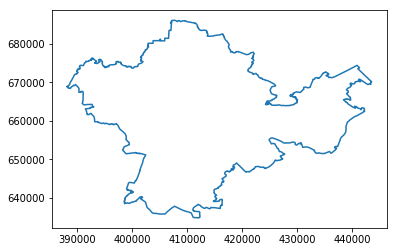

In [5]:
vector_file = 'data/powiat_chojnicki.shp'
vector_data = VectorData(vector_file)
vd = vector_data.get_vector_data('geometry', True)
vector_data.show_vector_data(vd)

In [6]:
vn = vector_data.reproject_geometry(epsg, True)

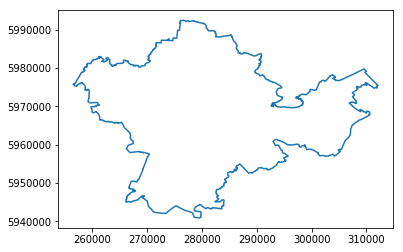

In [7]:
vector_data.show_vector_data(vn)

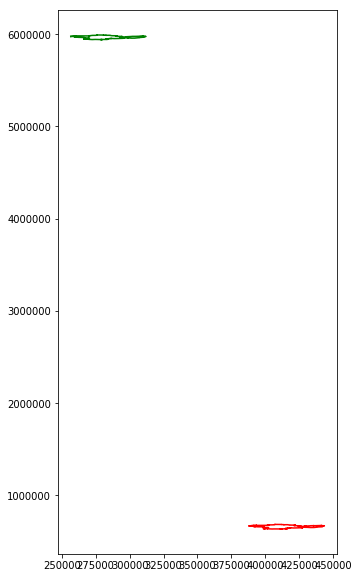

In [109]:
# Show to different projections

g_original = vd[0]['coordinates'][0]
g_original = np.asarray(g_original)
g_derived = vn[0]['coordinates'][0]
g_derived = np.asarray(g_derived)

plt.figure(figsize=(5,10))
plt.plot(g_original[:, 0], g_original[:, 1], color='red')
plt.plot(g_derived[:, 0], g_derived[:, 1], color='green')
plt.show()